# 04 — BTC/ETH Pair Research (Refined)

Fixes the broken pair notebook and focuses on Sharpe-driven diagnostics: equity curves, heatmaps, and marginal analysis.


In [12]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Add project root to path
sys.path.insert(0, '/Users/samgeng14/PycharmProjects/LunaExchange/Crypto')

# Local model helpers (uploaded alongside this notebook)
try:
    from pair_trading import (
        build_spread, adf_test, ou_mle,
        pair_signal_zscore, pair_returns, performance_summary
    )
except ImportError:
    print("Warning: pair_trading module not found. Defining fallback functions.")
    # Fallback: define minimal helper functions if module not available
    def build_spread(df, beta_window=180):
        log_b = np.log(df["BTC-USD_close"].astype(float))
        log_e = np.log(df["ETH-USD_close"].astype(float))
        return log_e - log_b
    
    def performance_summary(returns, position):
        return pd.DataFrame()

try:
    from mining import compute_mining_edge
except ImportError:
    print("Warning: mining module not found.")

pd.set_option("display.max_columns", 50)
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [11]:
print("BTC first valid:", raw["BTC-USD_close"].first_valid_index())
print("ETH first valid:", raw["ETH-USD_close"].first_valid_index())

print("BTC nonzero start:",
      raw.loc[raw["BTC-USD_close"] > 0].index.min())

print("ETH nonzero start:",
      raw.loc[raw["ETH-USD_close"] > 0].index.min())

BTC first valid: 2008-01-01 00:00:00
ETH first valid: 2008-01-01 00:00:00
BTC nonzero start: 2008-01-01 00:00:00
ETH nonzero start: 2008-01-01 00:00:00


In [3]:
def sharpe_ratio(r: pd.Series) -> float:
    r = r.dropna()
    if len(r) < 30 or r.std() == 0:
        return np.nan
    return float(np.sqrt(365) * r.mean() / r.std())

def pair_portfolio_returns(df: pd.DataFrame, beta_window: int, position: pd.Series, orientation: int = 1) -> pd.Series:
    log_b = np.log(df["BTC-USD_close"].astype(float))
    log_e = np.log(df["ETH-USD_close"].astype(float))
    minp = min(beta_window, max(30, beta_window // 3))
    cov = log_b.rolling(beta_window, min_periods=minp).cov(log_e)
    var = log_e.rolling(beta_window, min_periods=minp).var()
    beta = (cov / var).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    r_btc = df["BTC-USD_close"].astype(float).pct_change().fillna(0.0)
    r_eth = df["ETH-USD_close"].astype(float).pct_change().fillna(0.0)
    pos = position.reindex(df.index).fillna(0.0)
    gross = pos * (r_eth - beta * r_btc)
    if int(orientation) == -1:
        gross = -gross
    turnover = pos.diff().abs().fillna(0.0)
    costs = turnover * (FEE_BPS + SLIPPAGE_BPS) / 1e4
    return gross - costs


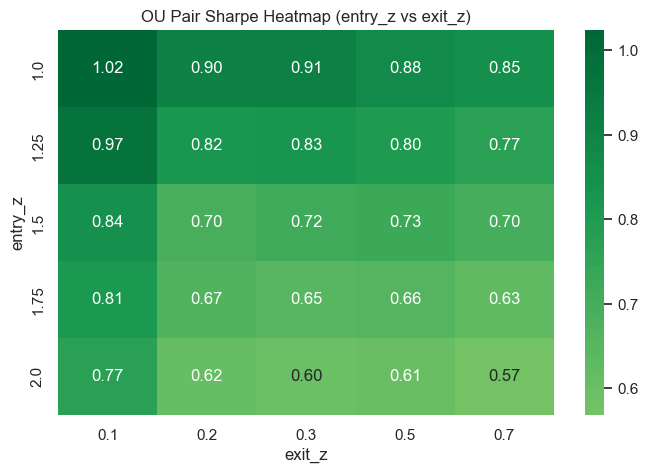

{'Sharpe': 1.0236262388456678,
 'entry_z': 1.0,
 'exit_z': 0.1,
 'orientation': 1,
 'returns': Date
 2017-11-13    0.000000
 2017-11-14    0.000000
 2017-11-15   -0.000000
 2017-11-16   -0.000000
 2017-11-17    0.000000
                 ...   
 2026-02-05   -0.050518
 2026-02-06    0.032999
 2026-02-07    0.028735
 2026-02-08   -0.011806
 2026-02-09    0.011409
 Length: 3008, dtype: float64,
 'position': Date
 2017-11-13    0.0
 2017-11-14    0.0
 2017-11-15    0.0
 2017-11-16    0.0
 2017-11-17    0.0
              ... 
 2026-02-05    1.0
 2026-02-06    1.0
 2026-02-07    1.0
 2026-02-08    1.0
 2026-02-09    1.0
 Length: 3008, dtype: float64}

In [4]:
beta_window = 180
spread = build_spread(df, beta_window=beta_window)
entry_grid = [1.0, 1.25, 1.5, 1.75, 2.0]
exit_grid = [0.1, 0.2, 0.3, 0.5, 0.7]
ou_window = 60
heat = pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float)
best = {"Sharpe": -np.inf}
for entry in entry_grid:
    for exit_z in exit_grid:
        if exit_z >= entry:
            continue
        pos = ou_signal_on_spread(spread, window=ou_window, entry_z=entry, exit_z=exit_z, long_short=True, smooth_sizing=False, max_leverage=1.0)
        r_plus = pair_portfolio_returns(df, beta_window, pos, orientation=1)
        r_minus = pair_portfolio_returns(df, beta_window, pos, orientation=-1)
        s_plus, s_minus = sharpe_ratio(r_plus), sharpe_ratio(r_minus)
        if np.nan_to_num(s_plus, nan=-9) >= np.nan_to_num(s_minus, nan=-9):
            s, orientation, r = s_plus, 1, r_plus
        else:
            s, orientation, r = s_minus, -1, r_minus
        heat.loc[entry, exit_z] = s
        if np.isfinite(s) and s > best["Sharpe"]:
            best = {"Sharpe": float(s), "entry_z": float(entry), "exit_z": float(exit_z), "orientation": int(orientation), "returns": r, "position": pos.reindex(df.index).fillna(0.0)}
plt.figure(figsize=(8, 5))
sns.heatmap(heat.astype(float), annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("OU Pair Sharpe Heatmap (entry_z vs exit_z)")
plt.xlabel("exit_z")
plt.ylabel("entry_z")
plt.show()
best


In [5]:
best_ou_pos = ou_signal_on_spread(spread, window=ou_window, entry_z=best["entry_z"], exit_z=best["exit_z"], long_short=True, smooth_sizing=False, max_leverage=1.0)
z_pos = zscore_signal_on_spread(spread, window=60, entry_z=1.25, exit_z=0.3, long_short=True, max_leverage=1.0)
trend_pos = trend_signal(pd.DataFrame({"spread": spread}), price_column="spread", fast_window=20, slow_window=90, long_only=False, leverage_aggressive=1.0, leverage_neutral=0.0, leverage_defensive=-1.0)
orientation = best["orientation"]
ret_ou = pair_portfolio_returns(df, beta_window, best_ou_pos, orientation=orientation)
ret_z = pair_portfolio_returns(df, beta_window, z_pos, orientation=orientation)
ret_trend = pair_portfolio_returns(df, beta_window, trend_pos, orientation=orientation)
ensemble_pos = (0.65 * best_ou_pos.reindex(df.index).fillna(0.0) + 0.25 * z_pos.reindex(df.index).fillna(0.0) + 0.10 * trend_pos.reindex(df.index).fillna(0.0)).clip(-1.0, 1.0)
ret_ensemble = pair_portfolio_returns(df, beta_window, ensemble_pos, orientation=orientation)
summary = build_summary_table({
    "OU Pair (tuned)": {"returns": ret_ou, "position": best_ou_pos},
    "Z Pair": {"returns": ret_z, "position": z_pos},
    "Trend Pair": {"returns": ret_trend, "position": trend_pos},
    "Ensemble Pair": {"returns": ret_ensemble, "position": ensemble_pos},
}).sort_values("Sharpe", ascending=False)
summary


,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
OU Pair (tuned),1.023626,1.353262,0.528687,-0.801604,0.659536,0.590559,0.576928,3008,7.054934
Ensemble Pair,0.978473,1.184895,0.258133,-0.483431,0.533960,0.267167,0.273045,3008,7.110705
Trend Pair,-0.075892,-0.097536,-0.198450,-0.887384,-0.223635,-0.044834,0.590758,3008,7.797558
Z Pair,-0.758132,-0.952527,-0.467881,-0.996018,-0.469751,-0.451038,0.594933,3008,9.035266


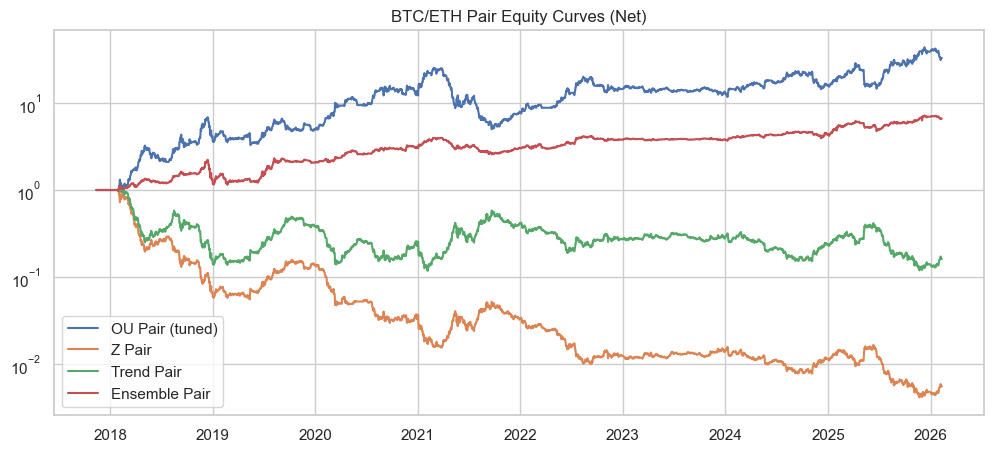

In [6]:
plt.figure(figsize=(12, 5))
for name, r in {"OU Pair (tuned)": ret_ou, "Z Pair": ret_z, "Trend Pair": ret_trend, "Ensemble Pair": ret_ensemble}.items():
    eq = (1 + r.fillna(0)).cumprod()
    plt.plot(eq.index, eq.values, label=name)
plt.yscale("log")
plt.title("BTC/ETH Pair Equity Curves (Net)")
plt.legend()
plt.show()


In [7]:
base_sharpe = sharpe_ratio(ret_ensemble)
rows = []
for name, (w_ou, w_z, w_tr) in {"Drop OU": (0.0, 0.7, 0.3), "Drop Z": (0.8, 0.0, 0.2), "Drop Trend": (0.7, 0.3, 0.0)}.items():
    pos = (w_ou * best_ou_pos.reindex(df.index).fillna(0.0) + w_z * z_pos.reindex(df.index).fillna(0.0) + w_tr * trend_pos.reindex(df.index).fillna(0.0)).clip(-1.0, 1.0)
    s = sharpe_ratio(pair_portfolio_returns(df, beta_window, pos, orientation=orientation))
    rows.append({"Scenario": name, "Sharpe": s, "MarginalImpact": base_sharpe - s})
marginal = pd.DataFrame(rows).sort_values("MarginalImpact", ascending=False)
marginal


,Scenario,Sharpe,MarginalImpact
0,Drop OU,-0.570265,1.548738
2,Drop Trend,0.923091,0.055381
1,Drop Z,1.153872,-0.175400


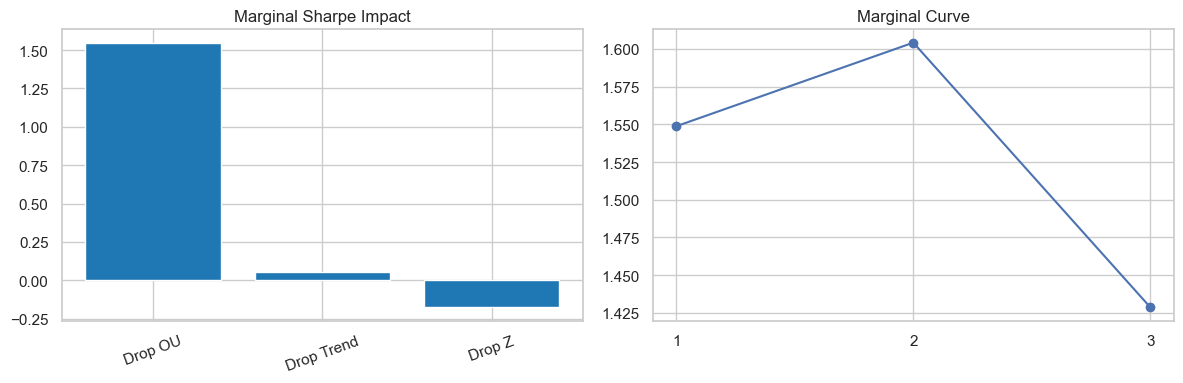

In [8]:
mc = marginal.sort_values("MarginalImpact", ascending=False).reset_index(drop=True)
mc["CumulativeImpact"] = mc["MarginalImpact"].cumsum()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].bar(mc["Scenario"], mc["MarginalImpact"], color="tab:blue")
ax[0].set_title("Marginal Sharpe Impact")
ax[0].tick_params(axis="x", rotation=20)
ax[1].plot(range(1, len(mc) + 1), mc["CumulativeImpact"], marker="o")
ax[1].set_xticks(range(1, len(mc) + 1))
ax[1].set_title("Marginal Curve")
plt.tight_layout(); plt.show()
